## Задача №1. 

#### Реализовать стохастическую генеративную модель как приложение на языке Python c помощью библиотеки pymc. Обучить модель на данных о числе новых выявленных случаев заболевания covid-19 в период с 01.01.2020 по 01.12.2020 в странах: Россия, Италия, Германия и Франция

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from __future__ import annotations
import time

import pytensor
import pytensor.tensor as pt

import numpy as np
import pandas as pd
import arviz as az
import pymc as pm

from scipy.special import gammainc 

In [3]:
az.style.use("arviz-darkgrid")

### Чтение данных

In [4]:
def load_individual_timeseries(name):
    base_url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series'
    url = f'{base_url}/time_series_covid19_{name}_global.csv'
    df = pd.read_csv(url, 
                     index_col=['Country/Region', 'Province/State', 'Lat', 'Long'])
    
    df['type'] = name.lower()
    df.columns.name = 'date'
    
    df = (df.set_index('type', append=True)
            .reset_index(['Lat', 'Long'], drop=True)
            .stack()
            .reset_index()
            .set_index('date')
         )
    
    df.index = pd.to_datetime(df.index)
    df.columns = ['country', 'state', 'type', 'cases']
    
    # Move HK to country level
    df.loc[df.state =='Hong Kong', 'country'] = 'Hong Kong'
    df.loc[df.state =='Hong Kong', 'state'] = np.nan
    
    # Aggregate large countries split by states
    df = pd.concat([df, 
                    (df.loc[~df.state.isna()]
                     .groupby(['country', 'date', 'type'])
                     .sum()
                     .rename(index=lambda x: x+' (total)', level=0)
                     .reset_index(level=['country', 'type']))
                   ])
    return df

def load_data(drop_states=False, p_crit=.05, filter_n_days_100=None):
    df = load_individual_timeseries('confirmed')
    df = df.rename(columns={'cases': 'confirmed'})
    if drop_states:
        # Drop states for simplicity
        df = df.loc[df.state.isnull()]
        
    # Estimated critical cases
    df = df.assign(critical_estimate=df.confirmed*p_crit)

    # Compute days relative to when 100 confirmed cases was crossed
    df.loc[:, 'days_since_100'] = np.nan
    for country in df.country.unique():
        if not df.loc[(df.country == country), 'state'].isnull().all():
            for state in df.loc[(df.country == country), 'state'].unique():
                df.loc[(df.country == country) & (df.state == state), 'days_since_100'] = \
                    np.arange(-len(df.loc[(df.country == country) & (df.state == state) & (df.confirmed < 100)]), 
                              len(df.loc[(df.country == country) & (df.state == state) & (df.confirmed >= 100)]))
        else:
            df.loc[(df.country == country), 'days_since_100'] = \
                np.arange(-len(df.loc[(df.country == country) & (df.confirmed < 100)]), 
                          len(df.loc[(df.country == country) & (df.confirmed >= 100)]))

    # Add deaths
    df_deaths = load_individual_timeseries('deaths')
    df_d = df_deaths.set_index(['country', 'state'], append=True)[['cases']]
    df_d.columns = ['deaths']

    df = (df.set_index(['country', 'state'], append=True)
            .join(df_d)
            .reset_index(['country', 'state'])
    )
    
    if filter_n_days_100 is not None:
        # Select countries for which we have at least some information
        countries = pd.Series(df.loc[df.days_since_100 >= filter_n_days_100].country.unique())
        df = df.loc[lambda x: x.country.isin(countries)]

    return df

def load_data_ecdc(p_crit=.05, filter_n_days_100=None):
    df = pd.read_csv('https://covid.ourworldindata.org/data/ecdc/full_data.csv', 
                     index_col='date', parse_dates=True)
    df = df.rename(columns={'location': 'country', 'total_cases': 'confirmed', 'total_deaths': 'deaths'})
        
    # Estimated critical cases
    df = df.assign(critical_estimate=df.confirmed*p_crit)

    # Compute days relative to when 100 confirmed cases was crossed
    df.loc[:, 'days_since_100'] = np.nan
    for country in df.country.unique():
        df.loc[(df.country == country), 'days_since_100'] = \
            np.arange(-len(df.loc[(df.country == country) & (df.confirmed < 100)]), 
                      len(df.loc[(df.country == country) & (df.confirmed >= 100)]))
  
    if filter_n_days_100 is not None:
        # Select countries for which we have at least some information
        countries = pd.Series(df.loc[df.days_since_100 >= filter_n_days_100].country.unique())
        df = df.loc[lambda x: x.country.isin(countries)]

    return df

In [5]:
df = load_data(drop_states=True, filter_n_days_100=2)

countries = df.country.unique()
n_countries = len(countries)

df = df.loc[lambda x: (x.days_since_100 >= 0)] # выбираем только те случаи, когда кол-во заболевших >100
df.head()

,country,state,type,confirmed,critical_estimate,days_since_100,deaths
date,,,,,,,
2020-03-28,Afghanistan,NaN,confirmed,106,5.3,0.0,2
2020-03-29,Afghanistan,NaN,confirmed,114,5.7,1.0,4
2020-03-30,Afghanistan,NaN,confirmed,114,5.7,2.0,4
2020-03-31,Afghanistan,NaN,confirmed,166,8.3,3.0,4
2020-04-01,Afghanistan,NaN,confirmed,192,9.6,4.0,4


In [6]:
# проверяем, что убрали все случаи с < 100 зараженных
df[df.confirmed < 100]

,country,state,type,confirmed,critical_estimate,days_since_100,deaths
date,,,,,,,


### Построение модели

In [22]:
def discretize_gamma_pmf(max_days: int, 
                         shape: float, 
                         rate: float
) -> np.ndarray:
    """
    Дискретизация непрерывного гамма-распределения в вероятности по целым дням (PMF).
    
    Аргументы:
        max_days : int
            Максимальное количество дней, до которого дискретизируем (0 .. max_days включительно).
        shape : float
            Параметр формы (α, "shape") гамма-распределения.
        rate : float
            Параметр скорости (β, "rate"), где scale = 1 / β.
            
    Возвращает:
        pmf : np.ndarray
            Массив вероятностей для целых дней 0, 1, ..., max_days.
    """
    # Создаём сетку точек 0, 1, 2, ..., max_days+1
    # Нужен диапазон на один элемент длиннее, чтобы можно было взять разности CDF[k+1] - CDF[k]
    grid = np.arange(0, max_days + 2, dtype=float)
    
    # Вычисляем значения функции распределения (CDF) для каждой точки grid.
    # Используем регуляризованную нижнюю неполную гамма-функцию:
    # gammainc(a, z) = (1/Γ(a)) * ∫₀ᶻ t^(a−1) e^(−t) dt
    # Для гамма-распределения с rate=β, scale=1/β, CDF(x) = gammainc(shape, βx)
    cdf = gammainc(shape, rate * grid)
    
    # Разностная функция: PMF[k] = CDF(k+1) - CDF(k)
    # Таким образом получаем вероятность того, что событие произошло между k и k+1 днём.
    pmf = np.diff(cdf)
    
    # Гарантируем, что нет отрицательных чисел из-за округлений (clip нижнюю границу 0, верхнюю 1)
    pmf = np.clip(pmf, 0, 1)
    
    # Обрезаем лишние элементы (на случай численного шума или слишком длинной сетки)
    pmf = pmf[:max_days + 1]
    pmf = pmf / pmf.sum() # Нормируем
    return pmf


def build_kernels(
    T: int,
    gi_shape: float = 2.6, gi_rate: float = 0.4,
    inc_shape: float = 1.352, inc_rate: float = 0.265,
    rep_shape: float = 5.48, rep_rate: float = 0.77,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Возвращает кортеж (g, xi):
      - g: PMF интервалов воспроизводства (generation intervals), длиной T+1 (используем с лагом 1)
      - xi: PMF задержки infection→report, длиной T+1 (для каузальной свёртки с I)
    """
    g = discretize_gamma_pmf(T, gi_shape, gi_rate)            # 0..T
    f_inc = discretize_gamma_pmf(T, inc_shape, inc_rate)      # incubation
    f_rep = discretize_gamma_pmf(T, rep_shape, rep_rate)      # onset->report
    xi = np.convolve(f_inc, f_rep)[:T+1]                      # 0..T
    xi[0] = 0
    xi = xi / xi.sum()
    return g, xi


def toeplitz_causal_kernel(kernel: np.ndarray, T: int) -> np.ndarray:
    """
    K[t, j] = kernel[t - j] для j <= t, иначе 0.
    Тогда (K @ x)[t] = sum_{tau=0..t} kernel[tau] * x[t - tau].
    """
    rows = []
    for t in range(T):
        row = np.concatenate([kernel[:t+1][::-1], np.zeros(T - (t+1))])
        rows.append(row)
    return np.stack(rows, axis=0)

In [24]:
kernel = np.array([0.0, 0.5, 0.3, 0.2])  # ξ0=0 (нет отчёта в тот же день), ξ1=0.5, ξ2=0.3...
K = toeplitz_causal_kernel(kernel, 4)
print("Каузальная Toeplitz-матрица K:\n", K, "\n")

Каузальная Toeplitz-матрица K:
 [[0.  0.  0.  0. ]
 [0.5 0.  0.  0. ]
 [0.3 0.5 0.  0. ]
 [0.2 0.3 0.5 0. ]] 



In [8]:
class GenerativeModel:
    def __init__(self, observed: pd.DataFrame, buffer_days: int = 10):
        """
        observed: DataFrame с индексом DatetimeIndex (daily), колонка 'confirmed' (новые случаи).
        buffer_days: добавим нулевых дней перед стартом — чтобы ядра не «упирались» в край.
        """
        assert isinstance(observed.index, pd.DatetimeIndex), "index должен быть DatetimeIndex (daily)."
        assert "confirmed" in observed.columns, "Нужна колонка 'confirmed' — новые случаи в день."

        # Создание нового временного индекса с учётом буферных дней
        new_index = pd.date_range(
            start=observed.index[0] - pd.Timedelta(days=buffer_days),  # начало сдвинуто назад на buffer_days
            end=observed.index[-1],  # до последней даты из данных
            freq="D",  # ежедневные интервалы
        )
        
        observed = observed.reindex(new_index, fill_value=0).copy()

        # Сохраняем
        self.model: pm.Model | None = None
        self._trace: az.InferenceData | None = None
        self._inference_data: az.InferenceData | None = None
        self.observed: pd.DataFrame = observed

    @property
    def trace(self):
        # Возвращает трассировку с результатами сэмплирования
        return self._trace

    @property
    def n_divergences(self) -> int:
        """
        Возвращает количество дивергенций (divergences) в результате выборки MCMC.
    
        Дивергенции — это предупреждения о том, что цепь MCMC (обычно NUTS)
        столкнулась с трудностями при переходе в некоторые области пространства параметров.
        Они часто сигнализируют о плохой геометрии постериора:
            - сильная корреляция между параметрами,
            - слишком узкие или криволинейные области высокой плотности,
            - плохой масштаб параметров или шаг интегратора.
    
        Высокое число дивергенций — тревожный признак: выборка может быть нестабильной,
        и оценки доверительных интервалов могут быть недостоверны.
        """
        if self._trace is None:
            return 0
    
        sstats = self._trace.sample_stats
        if "diverging" not in sstats:
            return 0
    
        # "diverging" — это массив булевых значений (True/False) для каждой итерации всех цепей.
        # Преобразуем его в numpy-массив и суммируем True → 1, False → 0.
        n_div = int(np.asarray(sstats["diverging"]).sum())
        return n_div

    
    @property
    def inference_data(self) -> az.InferenceData:
        """
        Возвращает объект ArviZ InferenceData, содержащий:
            - posterior (результаты MCMC-сэмплирования параметров),
            - posterior_predictive (предсказания модели на основе этих сэмплов).
    
        InferenceData — стандартный формат для анализа результатов PyMC:
        он хранит выборки, статистику, предсказания и позволяет легко строить графики,
        считать доверительные интервалы и проводить диагностику (R-hat, ESS и т.д.).
        """
  
        if self._inference_data is not None:
            return self._inference_data
        if self._trace is None:
            raise RuntimeError("Сначала вызови .sample().")
    
        # Входим в контекст модели и генерируем posterior predictive выборки.
        # Это делается на основе уже имеющихся выборок параметров self._trace:
        # PyMC берёт каждую комбинацию параметров из постериора и моделирует,
        # какие наблюдаемые данные (например, новые случаи заболеваний) могла бы породить модель.
        with self.model:
            idata = pm.sample_posterior_predictive(
                self._trace,
                extend_inferencedata=True,
                progressbar=True,
            )
        self._inference_data = idata
        return self._inference_data


    
    def build(
        self,
        gi_shape: float = 2.6, gi_rate: float = 0.4,          # интервал воспроизводства - 6-7 дней 
        inc_shape: float = 1.352, inc_rate: float = 0.265,    # инкубационный период - 5 дней
        rep_shape: float = 5.48, rep_rate: float = 0.77,      # задержка репортирования - 7 дней
    ):
        
        # --- ДАННЫЕ И ДЛИНА РЯДА ---
        y = self.observed["confirmed"].to_numpy(dtype=float)   # извлекаем суточные случаи как float
        T = len(y)                                             # длина временного ряда
    
        # --- ЯДРА: интервал генерации и задержка infection→report ---
        # g_np — PMF generation interval; xi_np — PMF суммарной задержки (incubation ⊗ onset→report)
        g_np, xi_np = build_kernels(
            T=T,
            gi_shape=gi_shape, gi_rate=gi_rate,
            inc_shape=inc_shape, inc_rate=inc_rate,
            rep_shape=rep_shape, rep_rate=rep_rate,
        )
        g_tail_np = g_np[1:T+1].copy()                         # используем g с лагом: g[1..] (передача не в тот же день)
        Xi_np = toeplitz_causal_kernel(xi_np[:T], T)           # Toeplitz-матрица каузальной свёртки задержки (T×T)
    
        # --- ВСПОМОГАТЕЛЬНОЕ: индексы дней недели для недельного эффекта ---
        dow = np.array([ts.dayofweek for ts in self.observed.index], dtype=int)  # 0..6
    
        # --- КООРДИНАТЫ ДЛЯ ARVIZ/ОСЕЙ ---
        coords = {"date": self.observed.index.values}          # координата времени: массив дат
    
        with pm.Model(coords=coords) as self.model:
            # --- MUTABLE DATA (можно подменять без пересборки графа при прогнозе) ---
            y_obs = pm.MutableData("y_obs", y, dims="date")    # наблюдаемые случаи
            g_tail = pm.MutableData("g_tail", g_tail_np)       # PMF g[1..] как данные передаются
            Xi = pm.MutableData("Xi", Xi_np)                   # матрица задержки infection→report
            dow_shared = pm.MutableData("dow", dow)            # индексы дня недели

            # ==========================
            #     ПАРАМЕТРЫ РЯДА
            # ==========================
    
            # --- Rt: случайное блуждание в лог-шкале ---
            log_R0 = pm.Normal("log_R0", mu=np.log(1.6), sigma=0.5)         # начальный уровень Rt (в лог-шкале)
            sigma_rw = pm.HalfNormal("sigma_rw", sigma=0.2)                 # шаг RW (гладкость траектории Rt)
            
            # нецентрированная параметризация приращений RW
            z_eps = pm.Normal("z_eps", mu=0.0, sigma=1.0, shape=T-1)
            eps   = pm.Deterministic("eps", z_eps * sigma_rw)
            
            log_R = pt.concatenate([log_R0[None], log_R0 + pt.cumsum(eps)])  # лог-Rt как кумулятивная сумма шагов
            R_t = pm.Deterministic(                                          # Rt в естественной шкале
                "R_t",
                pt.exp(log_R),                                    
                dims="date",
            )
    
            # --- Начальные инфекции и рекурсия I_t по renewal-уравнению ---
            L = 3                                                            # число «свободных» первых дней инфекций
            I0 = pm.HalfNormal("I_init", sigma=2.5, shape=L)                 # стартовые инфекции с общим масштабом
    
            tiny, huge = 1e-8, 1e9                                           # численные «стопоры» от нулей/переполнений
            def step(t, I_prev, R_vec, g_vec):
                # t — день; I_prev — уже частично заполненный вектор инфекций; R_vec — Rt; g_vec — PMF g[1..]
                max_s = pt.minimum(t, g_vec.shape[0])                        # сколько лагов доступно на шаге t
                past_I = I_prev[t - max_s:t]                                 # прошлые инфекции I_{t-s}
                past_g = g_vec[:max_s][::-1]                                 # соответствующие веса g_s (обратный порядок)
                lambda_t = pt.clip(pt.sum(past_I * past_g), tiny, huge)      # инфекционный потенциал (с клипом)
                I_t = pt.clip(R_vec[t] * lambda_t, tiny, huge)               # ожидаемые инфекции в день t
                return pt.set_subtensor(I_prev[t], I_t)                      # записываем I_t в позицию t
    
            I_init_full = pt.zeros((T,), dtype="float64")                    # вектор инфекций, изначально нули
            I_init_full = pt.set_subtensor(I_init_full[:L], I0)              # первые L позиций заполняем I0
    
            I_seq, _ = pytensor.scan(                                        # сканируем t=L..T-1 и заполняем I[t]
                fn=step,
                sequences=[pt.arange(L, T)],
                outputs_info=[I_init_full],
                non_sequences=[R_t, g_tail],
                strict=True,
            )
            I = pm.Deterministic("I", I_seq[-1], dims="date")                # полный вектор инфекций I[0..T-1]
    
            # --- Ожидаемые наблюдаемые случаи: свёртка infection→report ---
            mean_report_raw = pt.dot(Xi, I)                                  # каузальная свёртка через Toeplitz-матрицу
    
            # --- Эффект дня недели (мультипликативный, центрированный около 1) ---
            w_raw = pm.Dirichlet("weekday_raw", a=np.ones(7))                    # концентрация
            w = 7 * w_raw / pt.sum(w_raw)                                        # нормируем к среднему ≈ 1
            mean_report = pm.Deterministic(                                      # итоговый средний прогноз наблюдений
                "mean_report",
                pt.clip(mean_report_raw * w[dow_shared], 1e-6, 1e9),            # клип для численной устойчивости
                dims="date",
            )

            # --- Наблюдаемая модель: Poisson ---
            pm.Poisson("obs", 
                       mu=mean_report, 
                       observed=y_obs, 
                       dims="date"
            )
    
        return self



    def sample(
        self,
        draws: int = 1000,
        tune: int = 1000,
        chains: int = 4,
        cores: int = 4,
        target_accept: float = 0.9,
        init: str = "jitter+adapt_diag",
        random_seed: int | None = 42,
    ):
        if self.model is None:
            self.build()
        with self.model:
            self._trace = pm.sample(
                draws=draws,
                tune=tune,
                chains=chains,
                cores=cores,
                target_accept=target_accept,
                init=init,
                random_seed=random_seed,
                idata_kwargs={"log_likelihood": True},
            )
        # сбрасываем кеш ppc
        self._inference_data = None
        return self

In [9]:
class GenerativeModel2:
    def __init__(self, observed: pd.DataFrame, buffer_days: int = 10):
        """
        observed: DataFrame с индексом DatetimeIndex (daily), колонка 'confirmed' (новые случаи).
        buffer_days: добавим нулевых дней перед стартом — чтобы ядра не «упирались» в край.
        """
        assert isinstance(observed.index, pd.DatetimeIndex), "index должен быть DatetimeIndex (daily)."
        assert "confirmed" in observed.columns, "Нужна колонка 'confirmed' — новые случаи в день."

        # Создание нового временного индекса с учётом буферных дней
        new_index = pd.date_range(
            start=observed.index[0] - pd.Timedelta(days=buffer_days),  # начало сдвинуто назад на buffer_days
            end=observed.index[-1],  # до последней даты из данных
            freq="D",  # ежедневные интервалы
        )
        
        observed = observed.reindex(new_index, fill_value=0).copy()

        # Сохраняем
        self.model: pm.Model | None = None
        self._trace: az.InferenceData | None = None
        self._inference_data: az.InferenceData | None = None
        self.observed: pd.DataFrame = observed

    @property
    def trace(self):
        # Возвращает трассировку с результатами сэмплирования
        return self._trace

    @property
    def n_divergences(self) -> int:
        """
        Возвращает количество дивергенций (divergences) в результате выборки MCMC.
    
        Дивергенции — это предупреждения о том, что цепь MCMC (обычно NUTS)
        столкнулась с трудностями при переходе в некоторые области пространства параметров.
        Они часто сигнализируют о плохой геометрии постериора:
            - сильная корреляция между параметрами,
            - слишком узкие или криволинейные области высокой плотности,
            - плохой масштаб параметров или шаг интегратора.
    
        Высокое число дивергенций — тревожный признак: выборка может быть нестабильной,
        и оценки доверительных интервалов могут быть недостоверны.
        """
        if self._trace is None:
            return 0
    
        sstats = self._trace.sample_stats
        if "diverging" not in sstats:
            return 0
    
        # "diverging" — это массив булевых значений (True/False) для каждой итерации всех цепей.
        # Преобразуем его в numpy-массив и суммируем True → 1, False → 0.
        n_div = int(np.asarray(sstats["diverging"]).sum())
        return n_div

    
    @property
    def inference_data(self) -> az.InferenceData:
        """
        Возвращает объект ArviZ InferenceData, содержащий:
            - posterior (результаты MCMC-сэмплирования параметров),
            - posterior_predictive (предсказания модели на основе этих сэмплов).
    
        InferenceData — стандартный формат для анализа результатов PyMC:
        он хранит выборки, статистику, предсказания и позволяет легко строить графики,
        считать доверительные интервалы и проводить диагностику (R-hat, ESS и т.д.).
        """
  
        if self._inference_data is not None:
            return self._inference_data
        if self._trace is None:
            raise RuntimeError("Сначала вызови .sample().")
    
        # Входим в контекст модели и генерируем posterior predictive выборки.
        # Это делается на основе уже имеющихся выборок параметров self._trace:
        # PyMC берёт каждую комбинацию параметров из постериора и моделирует,
        # какие наблюдаемые данные (например, новые случаи заболеваний) могла бы породить модель.
        with self.model:
            idata = pm.sample_posterior_predictive(
                self._trace,
                extend_inferencedata=True,
                progressbar=True,
            )
        self._inference_data = idata
        return self._inference_data


    
    def build(
        self,
        gi_shape: float = 2.6, gi_rate: float = 0.4,          # интервал воспроизводства - 6-7 дней 
        inc_shape: float = 1.352, inc_rate: float = 0.265,    # инкубационный период - 5 дней
        rep_shape: float = 5.48, rep_rate: float = 0.77,      # задержка репортирования - 7 дней
    ):
        
        # --- ДАННЫЕ И ДЛИНА РЯДА ---
        y = self.observed["confirmed"].to_numpy(dtype=float)   # извлекаем суточные случаи как float
        T = len(y)                                             # длина временного ряда
    
        # --- ЯДРА: интервал генерации и задержка infection→report ---
        # g_np — PMF generation interval; xi_np — PMF суммарной задержки (incubation ⊗ onset→report)
        g_np, xi_np = build_kernels(
            T=T,
            gi_shape=gi_shape, gi_rate=gi_rate,
            inc_shape=inc_shape, inc_rate=inc_rate,
            rep_shape=rep_shape, rep_rate=rep_rate,
        )
        g_tail_np = g_np[1:T+1].copy()                         # используем g с лагом: g[1..] (передача не в тот же день)
        Xi_np = toeplitz_causal_kernel(xi_np[:T], T)           # Toeplitz-матрица каузальной свёртки задержки (T×T)
    
        # --- ВСПОМОГАТЕЛЬНОЕ: индексы дней недели для недельного эффекта ---
        dow = np.array([ts.dayofweek for ts in self.observed.index], dtype=int)  # 0..6
    
        # --- КООРДИНАТЫ ДЛЯ ARVIZ/ОСЕЙ ---
        coords = {"date": self.observed.index.values}          # координата времени: массив дат
    
        with pm.Model(coords=coords) as self.model:
            # --- MUTABLE DATA (можно подменять без пересборки графа при прогнозе) ---
            y_obs = pm.MutableData("y_obs", y, dims="date")    # наблюдаемые случаи
            g_tail = pm.MutableData("g_tail", g_tail_np)       # PMF g[1..] как данные передаются
            Xi = pm.MutableData("Xi", Xi_np)                   # матрица задержки infection→report
            dow_shared = pm.MutableData("dow", dow)            # индексы дня недели

            # ==========================
            #     ПАРАМЕТРЫ РЯДА
            # ==========================
    
            # --- Rt: случайное блуждание в лог-шкале ---
            log_R0 = pm.Normal("log_R0", mu=np.log(1.3), sigma=0.3)         # начальный уровень Rt (в лог-шкале)
            sigma_rw = pm.HalfNormal("sigma_rw", sigma=0.1)                 # шаг RW (гладкость траектории Rt)
            
            # нецентрированная параметризация приращений RW
            z_eps = pm.Normal("z_eps", mu=0.0, sigma=1.0, shape=T-1)
            eps   = pm.Deterministic("eps", z_eps * sigma_rw)
            
            log_R = pt.concatenate([log_R0[None], log_R0 + pt.cumsum(eps)])  # лог-Rt как кумулятивная сумма шагов
            R_t = pm.Deterministic(                                          # Rt в естественной шкале
                "R_t",
                pt.exp(log_R),                                    
                dims="date",
            )
    
            # --- Начальные инфекции и рекурсия I_t по renewal-уравнению ---
            L = 3                                                            # число «свободных» первых дней инфекций
            I0 = pm.HalfNormal("I_init", sigma=2.5, shape=L)                 # стартовые инфекции с общим масштабом
    
            tiny, huge = 1e-8, 1e9                                           # численные «стопоры» от нулей/переполнений
            def step(t, I_prev, R_vec, g_vec):
                # t — день; I_prev — уже частично заполненный вектор инфекций; R_vec — Rt; g_vec — PMF g[1..]
                max_s = pt.minimum(t, g_vec.shape[0])                        # сколько лагов доступно на шаге t
                past_I = I_prev[t - max_s:t]                                 # прошлые инфекции I_{t-s}
                past_g = g_vec[:max_s][::-1]                                 # соответствующие веса g_s (обратный порядок)
                lambda_t = pt.clip(pt.sum(past_I * past_g), tiny, huge)      # инфекционный потенциал (с клипом)
                I_t = pt.clip(R_vec[t] * lambda_t, tiny, huge)               # ожидаемые инфекции в день t
                return pt.set_subtensor(I_prev[t], I_t)                      # записываем I_t в позицию t
    
            I_init_full = pt.zeros((T,), dtype="float64")                    # вектор инфекций, изначально нули
            I_init_full = pt.set_subtensor(I_init_full[:L], I0)              # первые L позиций заполняем I0
    
            I_seq, _ = pytensor.scan(                                        # сканируем t=L..T-1 и заполняем I[t]
                fn=step,
                sequences=[pt.arange(L, T)],
                outputs_info=[I_init_full],
                non_sequences=[R_t, g_tail],
                strict=True,
            )
            I = pm.Deterministic("I", I_seq[-1], dims="date")                # полный вектор инфекций I[0..T-1]
    
            # --- Ожидаемые наблюдаемые случаи: свёртка infection→report ---
            mean_report_raw = pt.dot(Xi, I)                                  # каузальная свёртка через Toeplitz-матрицу
    
            # --- Эффект дня недели (мультипликативный, центрированный около 1) ---
            w_raw = pm.Dirichlet("weekday_raw", a=np.ones(7))                    # концентрация
            w = 7 * w_raw / pt.sum(w_raw)                                        # нормируем к среднему ≈ 1
            mean_report = pm.Deterministic(                                      # итоговый средний прогноз наблюдений
                "mean_report",
                pt.clip(mean_report_raw * w[dow_shared], 1e-6, 1e9),            # клип для численной устойчивости
                dims="date",
            )

            # --- Наблюдаемая модель: NegBin ---
            psi = pm.Exponential("psi", 1.0)
            pm.NegativeBinomial("obs", mu=mean_report, alpha=psi, observed=y_obs, dims="date")
    
        return self



    def sample(
        self,
        draws: int = 1000,
        tune: int = 1000,
        chains: int = 4,
        cores: int = 4,
        target_accept: float = 0.9,
        init: str = "jitter+adapt_diag",
        random_seed: int | None = 42,
    ):
        if self.model is None:
            self.build()
        with self.model:
            self._trace = pm.sample(
                draws=draws,
                tune=tune,
                chains=chains,
                cores=cores,
                target_accept=target_accept,
                init=init,
                random_seed=random_seed,
                idata_kwargs={"log_likelihood": True},
            )
        # сбрасываем кеш ppc
        self._inference_data = None
        return self

## Прогноз

In [10]:
# вспомогалка для кванта
def _q(x, q):
    return np.quantile(x, q, axis=0)

def forecast_oos(model: GenerativeModel,
                 start_date: str | pd.Timestamp,
                 end_date: str | pd.Timestamp,
                 n_samples: int | None = None,
                 random_seed: int | None = 123):
    """
    ВНЕвыборочный прогноз по датам (после обучающего окна).
    Возвращает (df_pred, df_rt) с агрегатами по предиктивному распределению и Rt.

    ПРЕДПОСЫЛКИ:
      - модель обучена на данных до 2020-12-01 включительно
      - в постериоре есть переменные: R_t, I, sigma_rw, z_eps, log_R0, weekday_raw
      - build_kernels и toeplitz_causal_kernel синхронны с обучением (xi[0]==0, g[1..])
      - наблюдаемая часть — Пуассон
    """
    rng = np.random.default_rng(random_seed)

    idata = model.trace  # posterior
    if idata is None:
        raise RuntimeError("Сначала вызови model.sample().")

    # Календарь и окно прогноза
    hist_index = model.observed.index
    train_last = hist_index[-1]  # у тебя это 2020-12-01
    start_date = pd.to_datetime(start_date)
    end_date   = pd.to_datetime(end_date)
    if start_date <= train_last:
        raise ValueError("start_date должен быть строго после последней обучающей даты.")
    future_index = pd.date_range(start=start_date, end=end_date, freq="D")
    H = len(future_index)  # горизонт прогноза (кол-во дней)

    # Длина истории и ядра
    y = model.observed["confirmed"].to_numpy(dtype=float)
    T = len(y)

    # Перестроим ядра на весь промежуток T+H
    g_full, xi_full = build_kernels(T + H,
                                    gi_shape=2.6, gi_rate=0.4,
                                    inc_shape=1.352, inc_rate=0.265,
                                    rep_shape=5.48, rep_rate=0.77)
    g_tail = g_full[1:]  # s>=1

    # Индексы дня недели для будущего
    dow_hist = np.array([ts.dayofweek for ts in hist_index], dtype=int)
    dow_fut  = np.array([ts.dayofweek for ts in future_index], dtype=int)

    # Достаём постериор как (samples, ...)
    def _stack(varname):
        arr = idata.posterior[varname].values  # (chain, draw, time?) или (chain, draw, ...)
        s = arr.shape
        return arr.reshape(s[0]*s[1], *s[2:])

    R_hist = _stack("R_t")              # (S, T)
    I_hist = _stack("I")                # (S, T)
    sigma_rw = _stack("sigma_rw").squeeze()  # (S,)
    log_R0   = _stack("log_R0").squeeze()    # (S,)
    z_eps    = _stack("z_eps")               # (S, T-1)
    w_raw    = _stack("weekday_raw")         # (S, 7)

    S = R_hist.shape[0]
    if n_samples is not None and n_samples < S:
        # сабсэмплируем, чтобы ускорить
        idx = rng.choice(S, size=n_samples, replace=False)
        R_hist, I_hist = R_hist[idx], I_hist[idx]
        sigma_rw, log_R0 = sigma_rw[idx], log_R0[idx]
        z_eps, w_raw = z_eps[idx], w_raw[idx]
        S = n_samples

    # Нормируем недельный эффект к среднему 1
    w = 7.0 * w_raw / w_raw.sum(axis=1, keepdims=True)  # (S,7)

    # Будем хранить выборки предсказанных наблюдений и Rt на будущем горизонте
    y_pred_samples = np.empty((S, H), dtype=float)
    Rt_future_samples = np.empty((S, H), dtype=float)

    # Проходим по выборкам
    for s in range(S):
        # 1) продлеваем лог-RW на H шагов: z_future ~ N(0,1)
        z_future = rng.normal(loc=0.0, scale=1.0, size=H)
        eps_future = sigma_rw[s] * z_future

        # восстановим лог-R на обучении из (log_R0, z_eps)
        log_R_path_hist = log_R0[s] + np.cumsum(z_eps[s] * sigma_rw[s])
        log_R_hist = np.concatenate([[log_R0[s]], log_R_path_hist])  # длина T

        # лог-R для будущего: продолжаем блуждание с последнего значения
        log_R_future = log_R_hist[-1] + np.cumsum(eps_future)
        R_future = np.exp(log_R_future)  # (H,)
        Rt_future_samples[s] = R_future

        # 2) продлеваем инфекции I_t по renewal
        I = np.zeros(T + H, dtype=float)
        I[:T] = I_hist[s]

        # аккуратно считаем λ_t = sum_{s>=1} g_s * I_{t-s}
        # используем доступную длину хвоста ядра
        max_lag = min(len(g_tail), T + H - 1)
        for t in range(T, T + H):
            s_max = min(max_lag, t)  # сколько лагов доступно
            lam = 0.0
            # g_tail[0] соответствует s=1
            if s_max > 0:
                past_I = I[t - s_max:t][::-1]       # I_{t-1}, I_{t-2}, ...
                past_g = g_tail[:s_max]             # g_1, g_2, ...
                lam = float(np.dot(past_I, past_g))
            I[t] = max(R_future[t - T] * lam, 1e-12)  # мягкий пол

        # 3) средние наблюдений на будущем горизонте через ξ-свёртку
        # mean_report[t] = sum_{τ>=0} ξ_τ * I_{t-τ}
        mean_future = np.zeros(H, dtype=float)
        for h in range(H):
            t = T + h
            tau_max = min(len(xi_full) - 1, t)  # не уходим за начало ряда
            if tau_max >= 0:
                # I[t] * xi_0 + I[t-1]*xi_1 + ...
                # но у нас xi_0 = 0 (по лекциям), так что всё честно
                mean_future[h] = float(np.dot(I[t - tau_max:t + 1][::-1],
                                              xi_full[:tau_max + 1]))

        # 4) недельный эффект
        mean_future *= w[s, dow_fut]

        # 5) наблюдаемые — Пуассон
        y_pred_samples[s] = rng.poisson(lam=np.clip(mean_future, 1e-12, 1e12))

    # Агрегируем по выборкам
    df_pred = pd.DataFrame({
        "mean_cases":  y_pred_samples.mean(axis=0),
        "median":      np.median(y_pred_samples, axis=0),
        "lo":          _q(y_pred_samples, 0.025),
        "hi":          _q(y_pred_samples, 0.975),
    }, index=future_index)

    df_rt = pd.DataFrame({
        "R_mean":   Rt_future_samples.mean(axis=0),
        "R_median": np.median(Rt_future_samples, axis=0),
        "R_lo":     _q(Rt_future_samples, 0.025),
        "R_hi":     _q(Rt_future_samples, 0.975),
    }, index=future_index)

    return df_pred, df_rt

## Задача №2. 

#### Оценить динамику эффективного репродуктивного числа R(t)

## Россия 

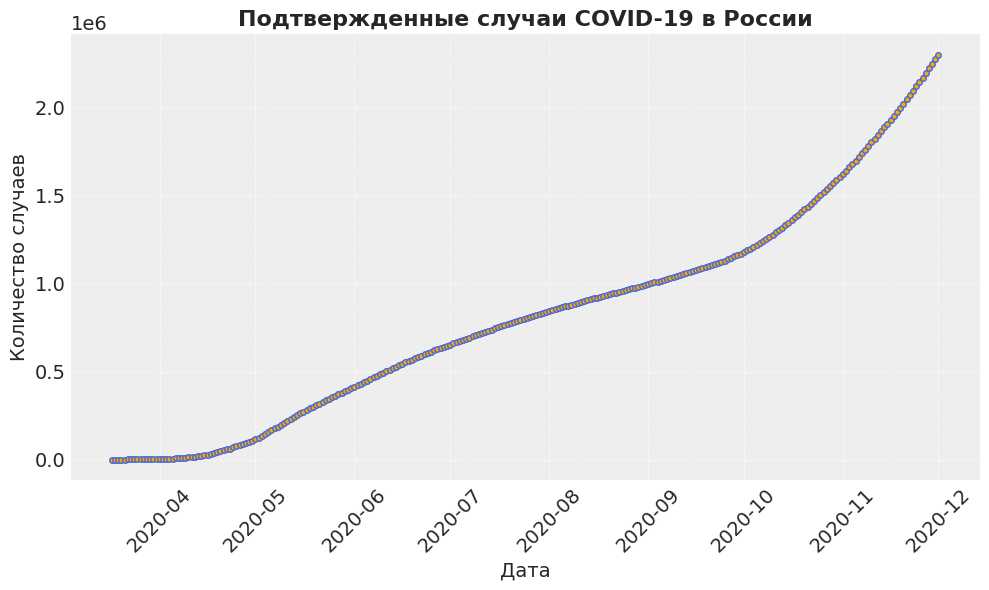

In [11]:
df_russia = df[df.country == 'Russia'].loc['2020-01-01':'2020-12-01']

plt.figure(figsize=(10,6))
plt.plot(df_russia.index, df_russia.confirmed, color='royalblue', linewidth=2, linestyle='-', marker='o', markersize=4, markerfacecolor='orange', markeredgewidth=1)
plt.title('Подтвержденные случаи COVID-19 в России', fontsize=16, fontweight='bold')
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество случаев', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### ПЕРВАЯ ПОПТЫКА (пуассон)

In [116]:
# --- создаём и обучаем модель ---
model = GenerativeModel(df_russia, buffer_days=3) 
model.build()  # построить граф
model.sample(
    draws=2000,        # итоговых выборок
    tune=1500,        # итераций адаптации
    chains=2,         # цепей MCMC
    cores=2,          # ядер CPU
    target_accept=0.9,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_R0, sigma_rw, z_eps, I_init, weekday_raw]


Sampling 2 chains for 1_500 tune and 2_000 draw iterations (3_000 + 4_000 draws total) took 14290 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [117]:
print(f"\nКоличество дивергенций: {model.n_divergences}\n")


Количество дивергенций: 5



In [118]:
# --- базовая сводка по ключевым параметрам ---
idata = model.inference_data
summary = az.summary(idata, var_names=["sigma_rw", "log_R0"], kind="stats")
print(summary.round(3))

Sampling: [obs]


           mean     sd  hdi_3%  hdi_97%
sigma_rw  0.070  0.065   0.016    0.237
log_R0    0.163  0.642  -1.517    0.536


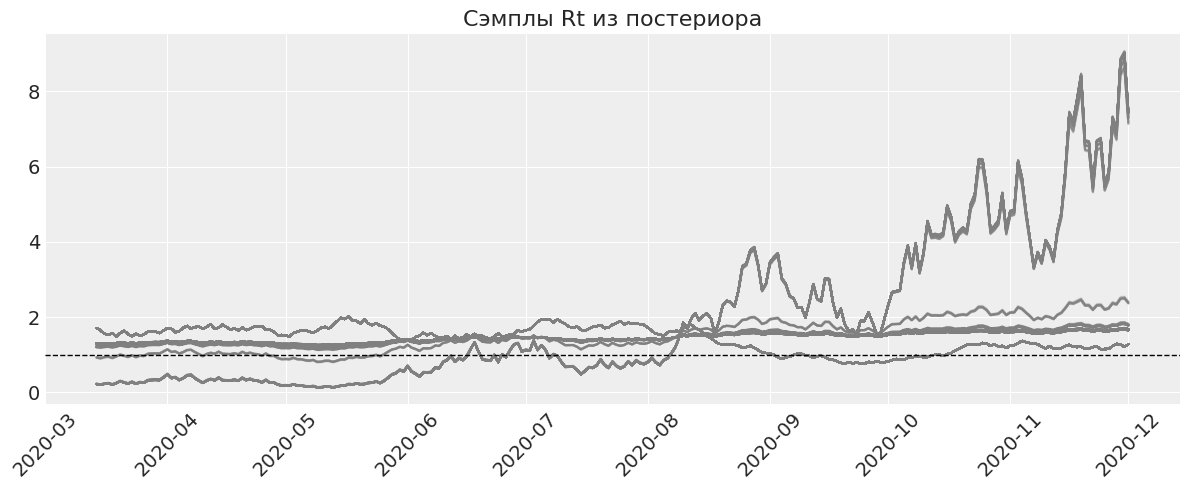

In [120]:
idata = model.inference_data

# (chain, draw, time)
Rt_samples = idata.posterior["R_t"].values
dates = pd.to_datetime(idata.posterior["R_t"].coords["date"].values)

S = 1000   # сколько траекторий нарисовать
idx_chain = np.random.choice(Rt_samples.shape[0], size=S, replace=True)
idx_draw  = np.random.choice(Rt_samples.shape[1], size=S, replace=True)

plt.figure(figsize=(12,5))
for c,d in zip(idx_chain, idx_draw):
    plt.plot(dates, Rt_samples[c, d, :], color="gray", alpha=0.1)

plt.axhline(1.0, linestyle="--", linewidth=1, color="black")
plt.title("Сэмплы Rt из постериора")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

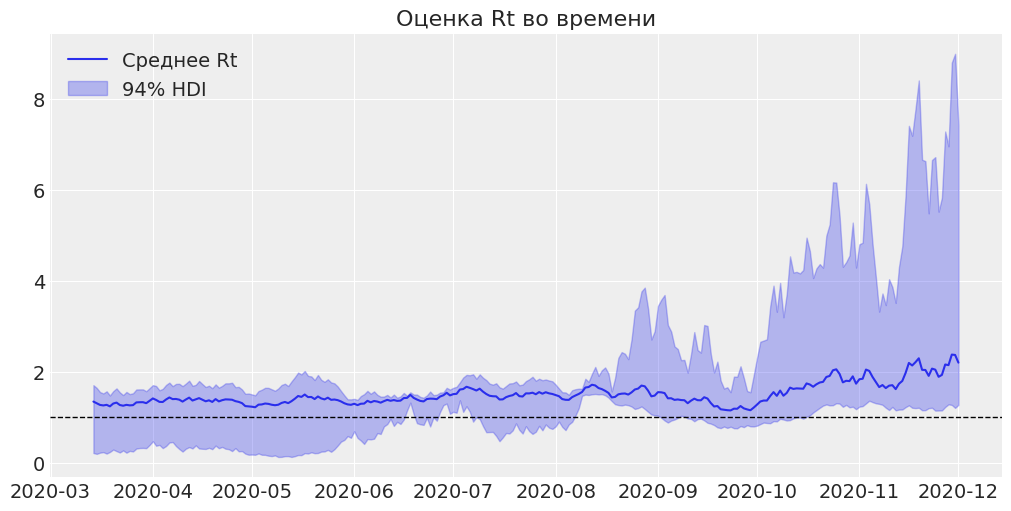

In [121]:
# --- усреднённые Rt по времени ---
rt_mean = idata.posterior["R_t"].mean(dim=("chain", "draw")).to_numpy().ravel()
rt_hdi  = az.hdi(idata, var_names=["R_t"], hdi_prob=0.94)["R_t"].to_numpy()

dates = model.observed.index
plt.figure(figsize=(10, 5))
plt.plot(dates, rt_mean, label="Среднее Rt", color="C0")
plt.fill_between(dates, rt_hdi[:, 0], rt_hdi[:, 1], color="C0", alpha=0.3, label="94% HDI")
plt.axhline(1.0, color="k", ls="--", lw=1)
plt.title("Оценка Rt во времени")
plt.legend()
plt.show()

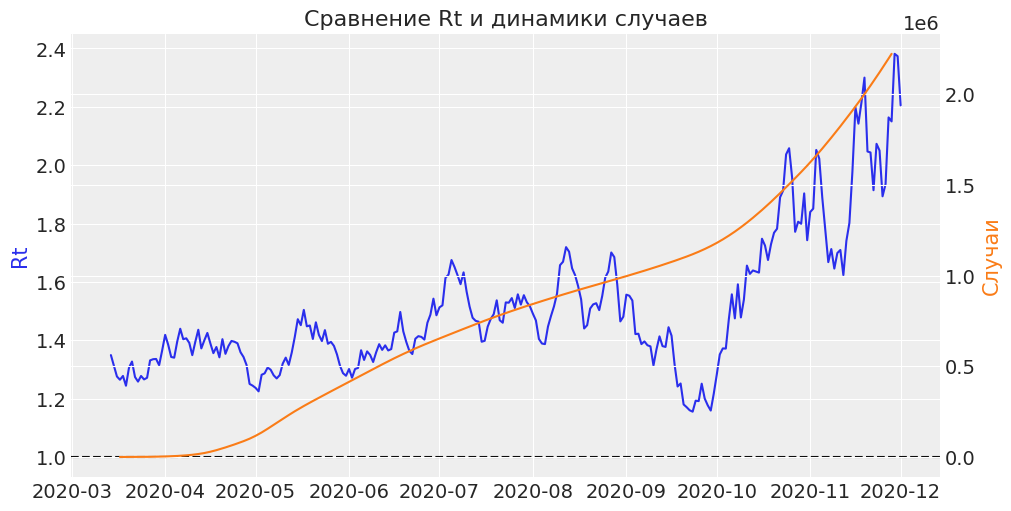

In [122]:
rt_mean = idata.posterior["R_t"].mean(dim=("chain", "draw")).to_numpy().ravel()
dates = model.observed.index
cases = model.observed["confirmed"].rolling(7, center=True).mean()  # сглаженные реальные данные

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(dates, rt_mean, color="C0", label="Rt")
ax1.axhline(1.0, color="k", ls="--")
ax1.set_ylabel("Rt", color="C0")

ax2 = ax1.twinx()
ax2.plot(dates, cases, color="C1", label="Случаи (7дн среднее)")
ax2.set_ylabel("Случаи", color="C1")

plt.title("Сравнение Rt и динамики случаев")
plt.show()

### ВТОРАЯ ПОПЫТКА (нег бин)

In [31]:
# --- создаём и обучаем модель ---
model2 = GenerativeModel2(df_russia, buffer_days=3) 
model2.build()  # построить граф
model2.sample(
    draws=500,         # итоговых выборок
    tune=500,          # итераций адаптации
    chains=2,          # цепей MCMC
    cores=3,           # ядер CPU
    target_accept=0.97,
)

ERROR! Session/line number was not unique in database. History logging moved to new session 620


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_R0, sigma_rw, z_eps, I_init, weekday_raw, psi]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 218 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [32]:
print(f"\nКоличество дивергенций: {model2.n_divergences}\n")


Количество дивергенций: 10



In [33]:
# --- базовая сводка по ключевым параметрам ---
idata = model2.inference_data
summary = az.summary(idata, var_names=["sigma_rw", "log_R0"], kind="stats")
print(summary.round(3))

Sampling: [obs]


           mean     sd  hdi_3%  hdi_97%
sigma_rw  0.150  0.013   0.136    0.163
log_R0    0.275  0.110   0.077    0.443


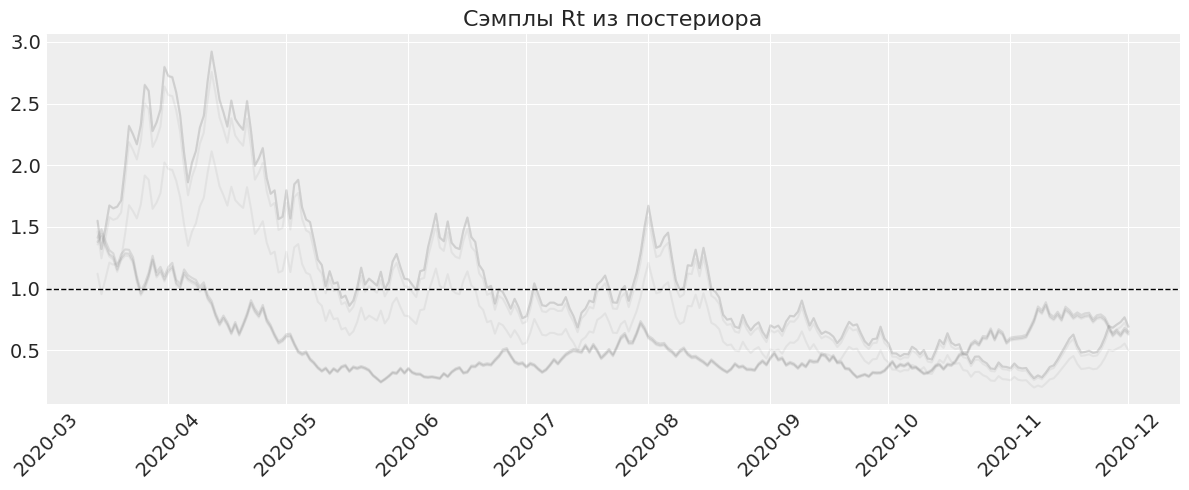

In [37]:
idata = model2.inference_data
Rt_samples = idata.posterior["R_t"].values
dates = pd.to_datetime(idata.posterior["R_t"].coords["date"].values)

S = 10   # сколько траекторий нарисовать
idx_chain = np.random.choice(Rt_samples.shape[0], size=S, replace=True)
idx_draw  = np.random.choice(Rt_samples.shape[1], size=S, replace=True)

plt.figure(figsize=(12,5))
for c,d in zip(idx_chain, idx_draw):
    plt.plot(dates, Rt_samples[c, d, :], color="gray", alpha=0.1)

plt.axhline(1.0, linestyle="--", linewidth=1, color="black")
plt.title("Сэмплы Rt из постериора")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

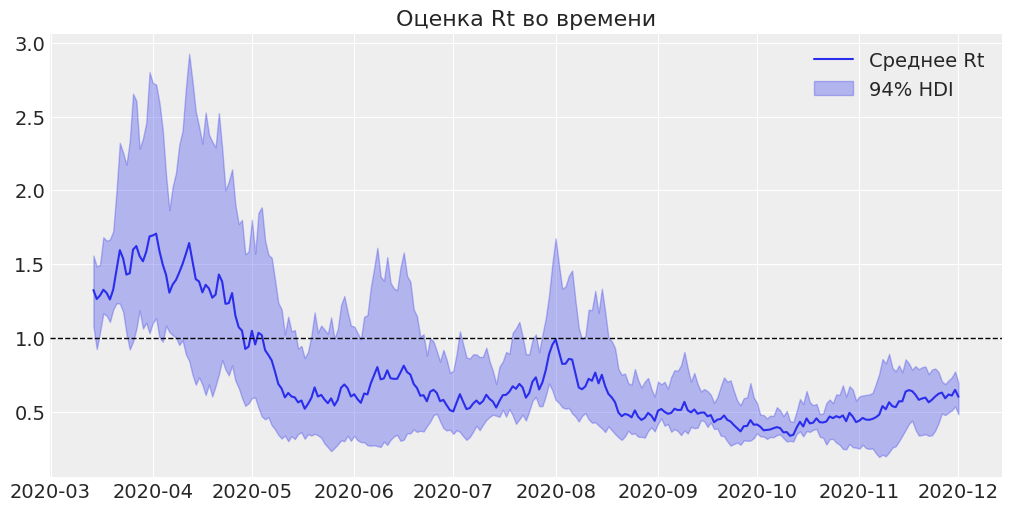

In [39]:
# --- усреднённые Rt по времени ---
rt_mean = idata.posterior["R_t"].mean(dim=("chain", "draw")).to_numpy().ravel()
rt_hdi  = az.hdi(idata, var_names=["R_t"], hdi_prob=0.94)["R_t"].to_numpy()

dates = model2.observed.index
plt.figure(figsize=(10, 5))
plt.plot(dates, rt_mean, label="Среднее Rt", color="C0")
plt.fill_between(dates, rt_hdi[:, 0], rt_hdi[:, 1], color="C0", alpha=0.3, label="94% HDI")
plt.axhline(1.0, color="k", ls="--", lw=1)
plt.title("Оценка Rt во времени")
plt.legend()
plt.show()

## Задача №3

#### Предсказать число зарегистрированных случаев в день и R(t) для диапазона дат 02.12.2020 по 14.12.2020. Сравнить с реальными данными

## Россия 

In [125]:
df_pred, df_rt = forecast_oos(
    model,
    start_date="2020-12-02",
    end_date="2020-12-14",
    n_samples=1000,          
    random_seed=2020,
)

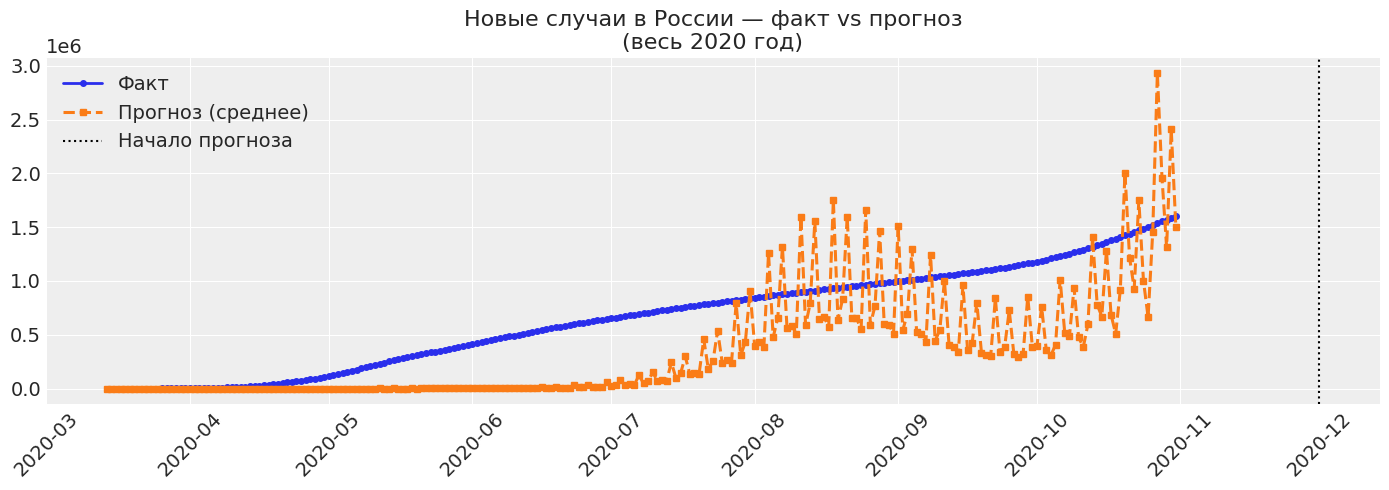

In [126]:
# --- фактические данные по России ---
ser_actual_all = df[df.country == "Russia"]["confirmed"].copy()
if not isinstance(ser_actual_all.index, pd.DatetimeIndex):
    ser_actual_all.index = pd.to_datetime(ser_actual_all.index)

# ограничиваем 2020 год
mask_2020 = (ser_actual_all.index >= "2020-01-01") & (ser_actual_all.index <= "2020-10-31")
actual_2020 = ser_actual_all.loc[mask_2020]

# --- исторический участок прогноза (posterior predictive) ---
idata = model.inference_data
dates_all = pd.to_datetime(idata.posterior_predictive["obs"].coords["date"].values)

# значения (chain, draw, time)
ppc = idata.posterior_predictive["obs"].values  

mean_hist = ppc.mean(axis=(0,1))
pred_hist = pd.Series(mean_hist, index=dates_all)

# оставляем только до 2020-12-01 включительно
pred_hist = pred_hist.loc[pred_hist.index <= "2020-12-01"]

# --- будущий участок прогноза (forecast_oos) ---
pred_future = df_pred["mean_cases"].copy()
# убеждаемся в индексе
pred_future.index = pd.to_datetime(pred_future.index)

# --- объединяем ---
pred_full = pd.concat([pred_hist, pred_future])
pred_full = pred_full.loc[(pred_full.index >= "2020-01-01") & (pred_full.index <= "2020-10-31")]

# --- выравниваем факт по тем же датам ---
actual_aligned = actual_2020.reindex(pred_full.index)

# --- финальный график ---
plt.figure(figsize=(14, 5))
plt.plot(actual_aligned.index, actual_aligned.values, marker="o",
         linewidth=2, markersize=4, label="Факт")
plt.plot(pred_full.index, pred_full.values, linestyle="--",
         linewidth=2.2, marker="s", markersize=5,
         label="Прогноз (среднее)")

# визуальная отметка: что модель не видела
plt.axvline(pd.to_datetime("2020-12-01"), color="black",
            linestyle=":", linewidth=1.5, label="Начало прогноза")

plt.title("Новые случаи в России — факт vs прогноз\n(весь 2020 год)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

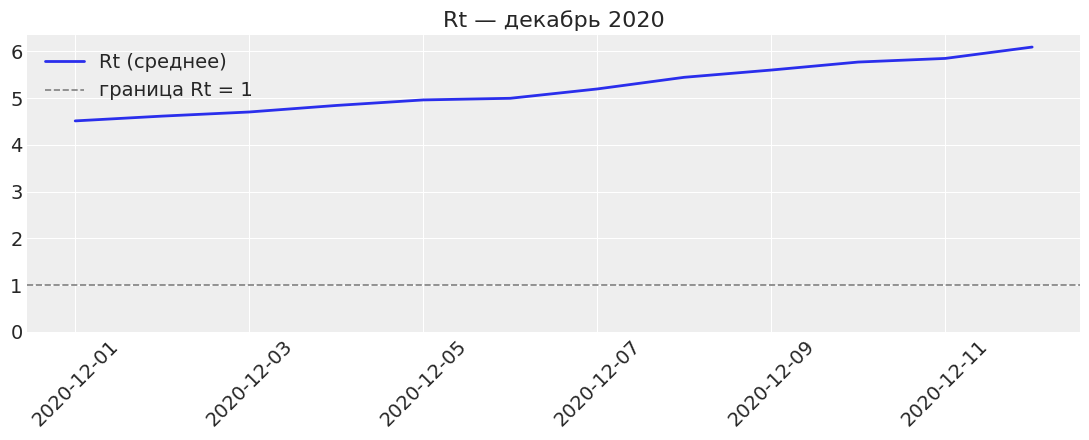

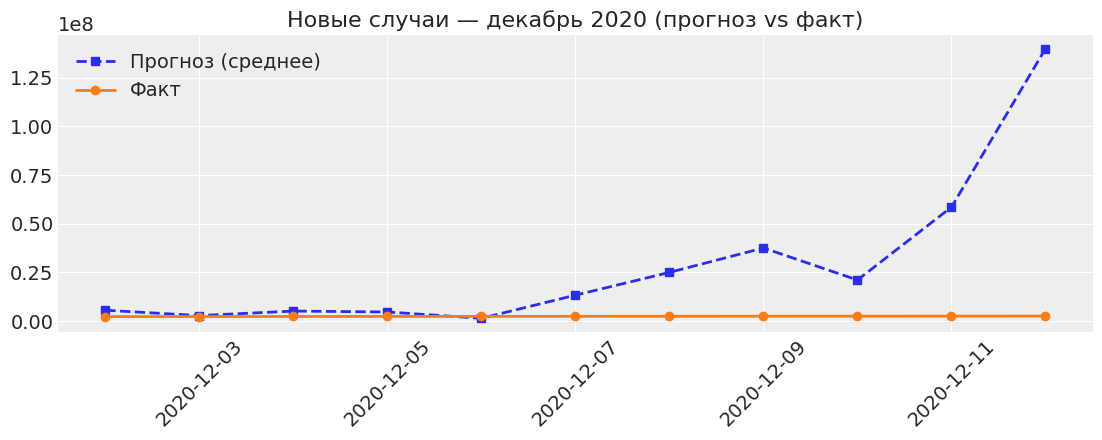

In [129]:
# --- Rt только декабрь ---
mask_rt_dec = (df_rt_full.index >= "2020-12-01") & (df_rt_full.index <= "2020-12-12")
df_rt_dec = df_rt_full.loc[mask_rt_dec]

plt.figure(figsize=(11, 4.5))
plt.plot(df_rt_dec.index, df_rt_dec["R_mean"], label="Rt (среднее)", linewidth=2.0)
plt.axhline(1.0, linestyle="--", linewidth=1.2, color="gray", label="граница Rt = 1")
plt.title("Rt — декабрь 2020")
plt.xticks(rotation=45)
plt.ylim(0, None)
plt.legend()
plt.tight_layout()
plt.show()

# --- прогноз случаев только декабрь ---
mask_pred_dec = (df_pred.index >= "2020-12-01") & (df_pred.index <= "2020-12-12")
df_pred_dec = df_pred.loc[mask_pred_dec]

actual_dec = ser_actual_all.reindex(df_pred_dec.index)

plt.figure(figsize=(11, 4.5))
plt.plot(df_pred_dec.index, df_pred_dec["mean_cases"],
         linestyle="--", marker="s", label="Прогноз (среднее)", linewidth=2.0)
plt.plot(actual_dec.index, actual_dec.values,
         marker="o", label="Факт", linewidth=2.0)
plt.title("Новые случаи — декабрь 2020 (прогноз vs факт)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
